In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [35]:
from datasets import load_dataset

# Load the Falah/Alzheimer_MRI dataset
dataset = load_dataset('Falah/Alzheimer_MRI', split='train')


In [92]:
# Split training data into train and validation tensorflow datasets

datasets = dataset.train_test_split(test_size=0.2)
ds_train_ = datasets["train"].to_tf_dataset(columns='image', shuffle=True, label_cols='label')
ds_valid_ = datasets["test"].to_tf_dataset(columns='image', shuffle=False, label_cols='label')

In [93]:
# Data Pipeline
# Converts image to float, and add one grayscale channel
def preprocess(image, label):
    image = tf.expand_dims(image, axis=-1)  # Shape becomes (128, 128, 1)
    image = tf.image.grayscale_to_rgb(image) # Shape become (128, 128, 3)
    
    image = tf.cast(image, tf.float32)
    # Normalize pixel values to [0, 1]
    image /= 255.0
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(preprocess)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(preprocess)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

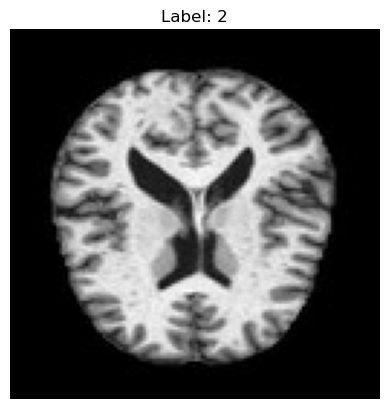

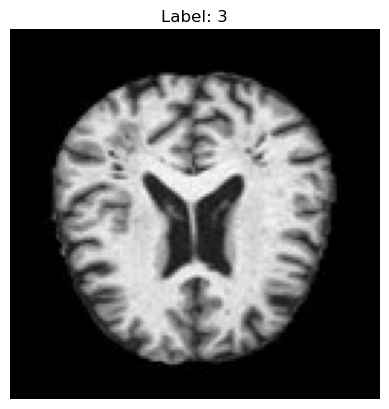

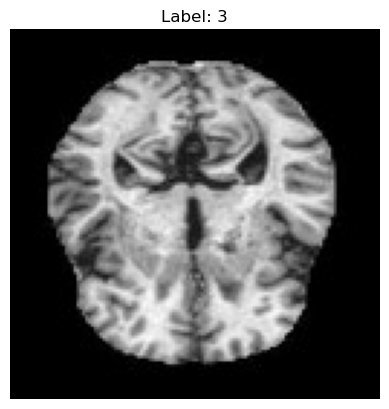

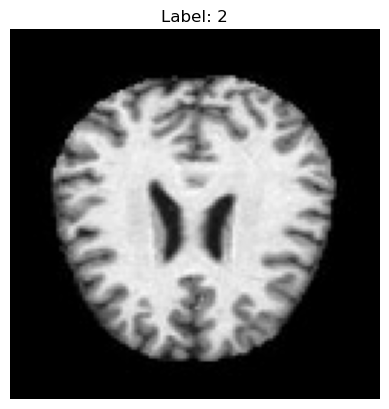

2024-11-14 17:06:31.011923: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


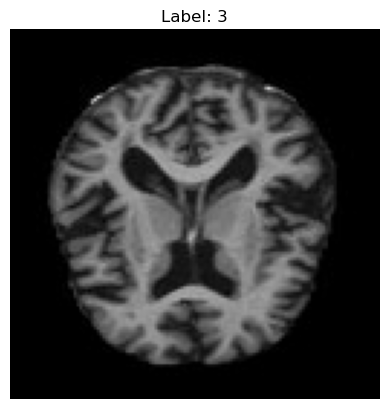

In [94]:
# Take a look at some of our sample MRI data
for image, label in ds_train.take(5): 
    # Convert image to numpy array and display with matplotlib 
    plt.imshow(image.numpy()) # Convert TensorFlow tensor to a NumPy array
    plt.title(f"Label: {label.numpy()}") # Print label
    plt.axis('off')
    plt.show()

In [96]:
# Batch our datasets
ds_train = ds_train.batch(batch_size=64)
ds_valid = ds_valid.batch(batch_size=64)

In [78]:
# Now import VGG16 base model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable =False

In [84]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(4, activation='softmax'),
])

In [85]:
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy', # As labels are in form of integers 0-3
    metrics = ['accuracy']
)

In [86]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=10,
    verbose=True
)

Epoch 1/10


2024-11-14 16:53:51.942485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-14 16:53:52.031298: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_2.


64/64 [==============================] - ETA: 0s - loss: 5.6689 - accuracy: 0.3555

2024-11-14 16:54:38.377847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 60s 911ms/step - loss: 5.6689 - accuracy: 0.3555 - val_loss: 6.1541 - val_accuracy: 0.3350
Epoch 2/10
64/64 [==============================] - 61s 946ms/step - loss: 4.3923 - accuracy: 0.3511 - val_loss: 2.9524 - val_accuracy: 0.3350
Epoch 3/10
64/64 [==============================] - 50s 781ms/step - loss: 2.2492 - accuracy: 0.3970 - val_loss: 1.9680 - val_accuracy: 0.4785
Epoch 4/10
64/64 [==============================] - 49s 768ms/step - loss: 1.7410 - accuracy: 0.4680 - val_loss: 1.5620 - val_accuracy: 0.4805
Epoch 5/10
64/64 [==============================] - 59s 927ms/step - loss: 1.3617 - accuracy: 0.4680 - val_loss: 1.1860 - val_accuracy: 0.4824
Epoch 6/10
64/64 [==============================] - 54s 853ms/step - loss: 1.0888 - accuracy: 0.4695 - val_loss: 1.0279 - val_accuracy: 0.4912
Epoch 7/10
64/64 [==============================] - 49s 762ms/step - loss: 1.0375 - accuracy: 0.4675 - val_loss: 1.0238 - val_accuracy: 0.4941
Epoch 8/10

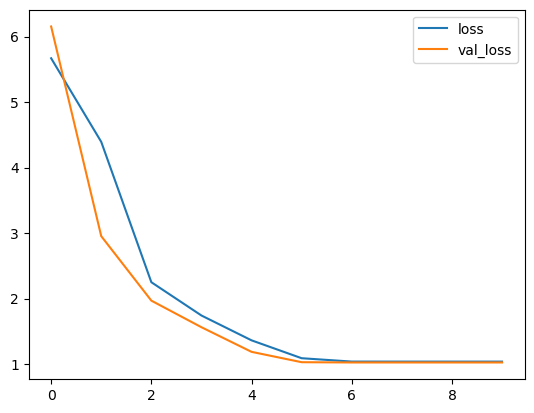

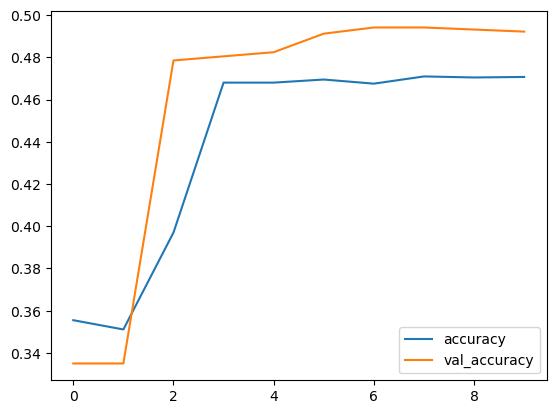

In [90]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();